# PD Model Monitoring

In [1]:
%load_ext autoreload
%autoreload 2

## Change project directory (google colab)

In [2]:
import os
os.chdir('/content/drive/MyDrive/projects/credit-risk-modelling-udemy/notebooks/')
os.listdir('../')

['venv-hpx360-win',
 'data',
 'src',
 '.git',
 'requirements.txt',
 'README.md',
 'src.egg-info',
 'setup.py',
 'reports',
 'outputs',
 'notebooks',
 '.gitignore']

In [5]:
!pip install -e ../.

Obtaining file:///content/drive/MyDrive/projects/credit-risk-modelling-udemy
  Running setup.py develop for src


## Some Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import src
from src.project.config import PROJECT_DIR
import json

## Load Data

In [14]:
fpaths = {subset: os.path.join(PROJECT_DIR, 'outputs', f'loan_data_2007_2014_{subset}_prepared_for_pd_model_nb3.pkl') for subset in ['train', 'test']}
df_train = pd.read_pickle(fpaths['train'])
df_test = pd.read_pickle(fpaths['test'])

In [15]:
fpath = os.path.join(PROJECT_DIR, 'outputs', 'loan_data_2015_prepared_for_pd_model_nb3.pkl')
df_new = pd.read_pickle(fpath)

In [6]:
infile = os.path.join(PROJECT_DIR, 'outputs', 'dummy_vars_ref_cats.json')
with open(infile, 'r') as f:
    d = json.load(f)

DUMMY_VARIABLES = d['DUMMY_VARIABLES']
REFERENCE_CATEGORIES = d['REFERENCE_CATEGORIES']

## Load Scorecard

In [7]:
fpath = os.path.join(PROJECT_DIR, 'outputs', 'scorecard.csv')
df_scorecard = pd.read_csv(fpath)
df_scorecard

,feature_name_orig,feature_name,coefficient,p_value,score_calculation,score_preliminary,score_difference,score_final
0,intercept,intercept,1.319336,NaN,523.921498,524.0,0.078502,524.0
1,annual_inc,annual_inc:<=28000,0.000000,NaN,0.000000,0.0,0.000000,-1.0
2,annual_inc,annual_inc:28000-45000,0.067684,3.784238e-03,6.584299,7.0,0.415701,7.0
3,annual_inc,annual_inc:45000-49000,0.151736,1.635146e-07,14.760872,15.0,0.239128,15.0
4,annual_inc,annual_inc:49000-62983,0.205341,1.209586e-17,19.975476,20.0,0.024524,20.0
...,...,...,...,...,...,...,...,...
63,term_int,term_int:36,0.000000,NaN,0.000000,0.0,0.000000,0.0
64,term_int,term_int:60,-0.033412,1.486068e-02,-3.250269,-3.0,0.250269,-3.0
65,verification_status,verification_status:Verified,0.000000,NaN,0.000000,0.0,0.000000,0.0
66,verification_status,verification_status:Source Verified,-0.014809,2.620121e-01,-1.440575,-1.0,0.440575,-1.0


In [11]:
scorecard_scores = df_scorecard[['score_final']].to_numpy()

In [16]:
df_train['intercept'] =  1
df_new['intercept'] = 1
df_train = df_train[df_scorecard['feature_name'].values]
df_new = df_new[df_scorecard['feature_name'].values]

In [17]:
df_train['score'] = df_train.dot(scorecard_scores)
df_new['score'] = df_new.dot(scorecard_scores)


In [42]:
end_interval = pd._libs.interval.Interval(800, 850, closed='both')
end_interval

Interval(800, 850, closed='both')

In [49]:
cats = [f'{score}-{score+50}' for score in range(300, 850, 50)]
cats

['300-350',
 '350-400',
 '400-450',
 '450-500',
 '500-550',
 '550-600',
 '600-650',
 '650-700',
 '700-750',
 '750-800',
 '800-850']

In [51]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(cats, ordered=True)

In [54]:
df_train['score_binned'] = pd.cut(df_train['score'], bins=range(300, 850+50, 50), right=False)
df_train['score_binned'] = df_train['score_binned'].apply(lambda intrvl: f'{intrvl.left}-{intrvl.right}').astype(cat_type)
score_dummies = pd.get_dummies(df_train['score_binned'], prefix='score', prefix_sep=':')
df_train = pd.concat([df_train, score_dummies], axis=1)

df_new['score_binned'] = pd.cut(df_new['score'], bins=range(300, 850+50, 50), right=False)
df_new['score_binned'] = df_new['score_binned'].apply(lambda intrvl: f'{intrvl.left}-{intrvl.right}').astype(cat_type)
score_dummies = pd.get_dummies(df_new['score_binned'], prefix='score', prefix_sep=':')
df_new = pd.concat([df_new, score_dummies], axis=1)



## Population Stability Index

In [82]:
psi_train = df_train.drop(['intercept', 'score'], axis=1).sum()/df_train.shape[0]
psi_new = df_new.drop(['intercept', 'score'], axis=1).sum()/df_new.shape[0]

In [83]:
psi_df = pd.concat([psi_train, psi_new], axis=1).reset_index().rename(columns={'index': 'feature_name', 0:'prop_train', 1: 'prop_new'})
psi_df['feature_name_orig'] = psi_df['feature_name'].str.split(':').str[0]
psi_df = psi_df[['feature_name_orig', 'feature_name', 'prop_train', 'prop_new']]
psi_df

,feature_name_orig,feature_name,prop_train,prop_new
0,annual_inc,annual_inc:<=28000,0.052586,0.049139
1,annual_inc,annual_inc:28000-45000,0.182670,0.167445
2,annual_inc,annual_inc:45000-49000,0.061770,0.058564
3,annual_inc,annual_inc:49000-62983,0.203108,0.197082
4,annual_inc,annual_inc:62983-67000,0.049441,0.048804
...,...,...,...,...
73,score,score:600-650,0.253892,0.237541
74,score,score:650-700,0.167703,0.230029
75,score,score:700-750,0.099349,0.194391
76,score,score:750-800,0.043654,0.161522


In [84]:
psi_df_melt = psi_df.melt(id_vars=['feature_name_orig', 'feature_name'], value_vars=['prop_train', 'prop_new'], 
                          var_name='dataset', value_name='prop')
psi_df_melt

,feature_name_orig,feature_name,dataset,prop
0,annual_inc,annual_inc:<=28000,prop_train,0.052586
1,annual_inc,annual_inc:28000-45000,prop_train,0.182670
2,annual_inc,annual_inc:45000-49000,prop_train,0.061770
3,annual_inc,annual_inc:49000-62983,prop_train,0.203108
4,annual_inc,annual_inc:62983-67000,prop_train,0.049441
...,...,...,...,...
151,score,score:600-650,prop_new,0.237541
152,score,score:650-700,prop_new,0.230029
153,score,score:700-750,prop_new,0.194391
154,score,score:750-800,prop_new,0.161522


In [92]:
feat_names_orig = psi_df_melt['feature_name_orig'].unique()
num_plots = len(feat_names_orig)//2
num_plots

7

In [96]:
psi_df_melt.set_index('feature_name_orig', inplace=True)

In [97]:
feat_names_orig

array(['annual_inc', 'dti', 'emp_length_int', 'grade', 'home_ownership',
       'initial_list_status', 'int_rate', 'mths_since_issue_d',
       'mths_since_last_delinq', 'mths_since_last_record', 'purpose',
       'term_int', 'verification_status', 'score'], dtype=object)

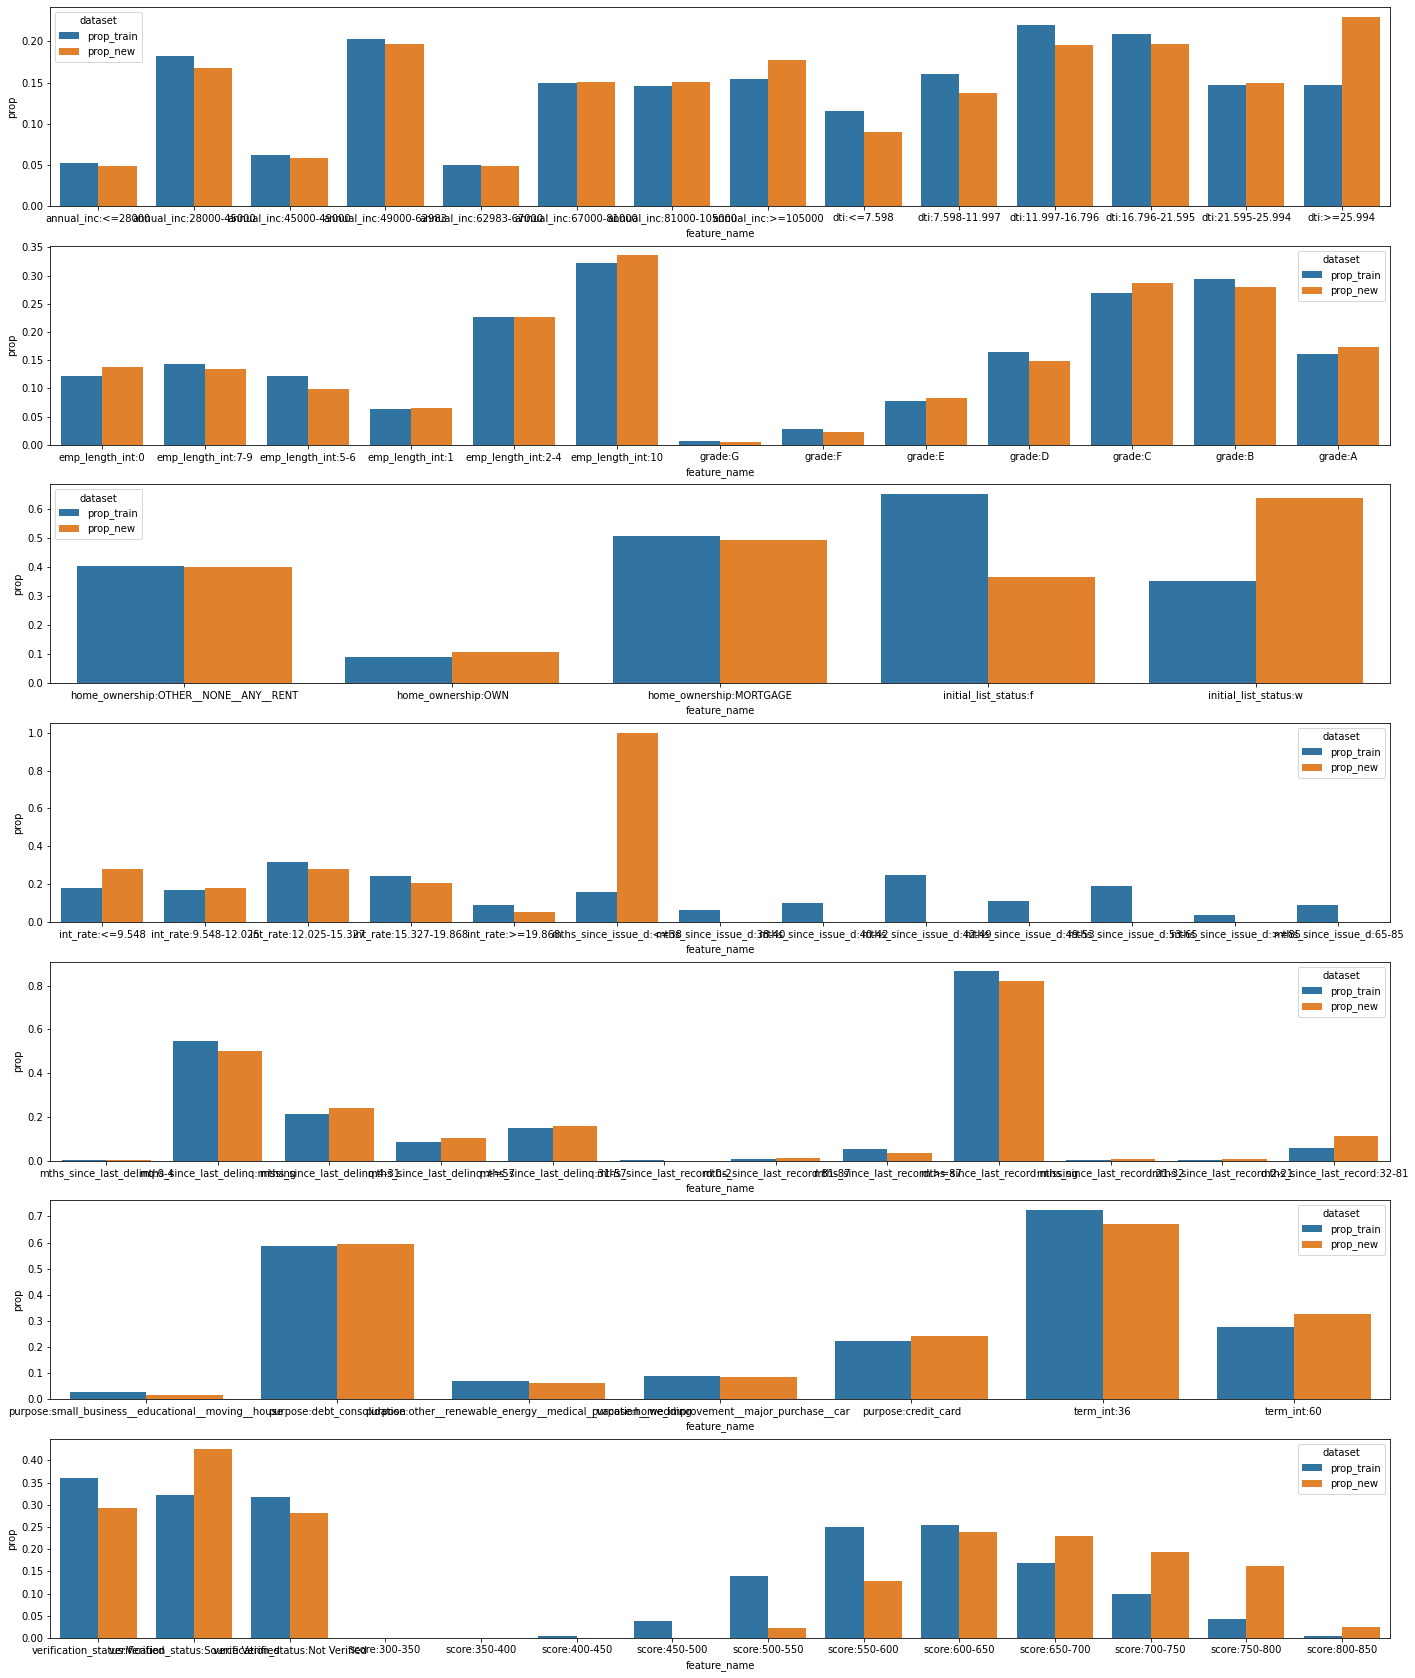

In [102]:
import seaborn as sns
fig, axn = plt.subplots(num_plots, 1, figsize=(24, 30))

for i, ax in enumerate(axn):
    if i != num_plots:
        d = psi_df_melt.loc[feat_names_orig[2*i:2*(i+1)]]
    else:
        d = psi_df_melt.loc[feat_names_orig[i:]]

    sns.barplot(x='feature_name', y='prop', hue='dataset', data=d, ax=ax)

In [107]:
psi_df['contribution'] = (psi_df['prop_new'] - psi_df['prop_train'])*np.log(psi_df['prop_new']/psi_df['prop_train'])
psi_df['contribution'].fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [108]:
psi_df.groupby('feature_name_orig')['contribution'].sum()

feature_name_orig
annual_inc                0.005224
dti                       0.050334
emp_length_int            0.007619
grade                     0.006775
home_ownership            0.004275
initial_list_status       0.333717
int_rate                  0.075191
mths_since_issue_d             inf
mths_since_last_delinq    0.011132
mths_since_last_record    0.064306
purpose                   0.008013
score                          inf
term_int                  0.013099
verification_status       0.048219
Name: contribution, dtype: float64